<a href="https://colab.research.google.com/github/Mehedi16009/Colab-DAG-Scheduling-Experiments/blob/main/Implementation_of_Gang_Task_Graph_Response_Time_Analysis_(RTA)_and_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 0) Quick environment check (Colab-safe)
# @markdown **Purpose:** Verify runtime & versions. No heavy installs here.
# @markdown This notebook is **Google Colab-compatible**.

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import torch, torchvision
    print("PyTorch:", torch.__version__)
    print("TorchVision:", torchvision.__version__)
except Exception as e:
    print("PyTorch/TorchVision not preinstalled (fine for sections 1–8).")


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu126
TorchVision: 0.23.0+cu126


In [2]:
# @title 1) Lightweight installs (NetworkX + Matplotlib only)
# @markdown **Purpose:** Install only what we need for graphs/plots (fast).
# @markdown We intentionally avoid heavy/fragile packages.

!pip -q install networkx matplotlib


In [3]:
# @title 2) Imports, device info, and seeding
# @markdown **Purpose:** Centralize imports, device info, and reproducible seeds.

import math, random, heapq, time
from typing import Dict, Tuple, List

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Seeding for reproducibility
def set_all_seeds(seed: int = 1234):
    random.seed(seed)
    np.random.seed(seed)

set_all_seeds(1234)
print("Seeds set ✔")


Seeds set ✔


In [4]:
# @title 3) Parameters (resources) and helpers
# @markdown **Purpose:** Define resource capacities and small utils.
# @markdown Values are tiny by default so cells complete in seconds.

# @param {type:"integer"}
CPU_CORES = 4
# @param {type:"integer"}
GPU_SLOTS = 1  # model GPU as 1 "slot" (semi-work-conserving visible later)

RESOURCES: Dict[str, int] = {"CPU": CPU_CORES, "GPU": GPU_SLOTS}
print("Resources:", RESOURCES)

def ensure_feasible_m(ce: str, mi: int) -> int:
    """Clamp gang size to capacity of its CE (prevents unschedulable tasks)."""
    return max(1, min(mi, RESOURCES[ce]))


Resources: {'CPU': 4, 'GPU': 1}


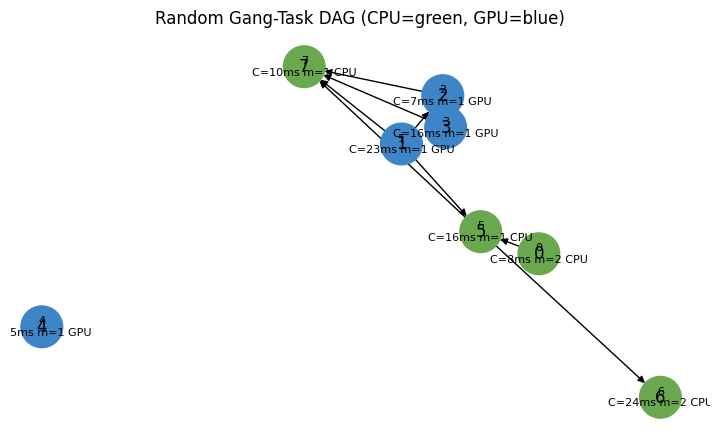

Nodes: 8 | Edges: 8


In [5]:
# @title 4) DAG generation (Colab-safe) + quick draw
# @markdown **Purpose:** Create random gang-task DAGs without pygraphviz, and draw quickly.
# @markdown We keep GPU gangs `mi=1` (fast & always placeable with GPU_SLOTS=1).

# @param {type:"integer"}
DEFAULT_N = 8           # small → fast
# @param {type:"number"}
DEFAULT_EDGE_PROB = 0.25
# @param {type:"integer"}
WCET_MIN_MS = 5
# @param {type:"integer"}
WCET_MAX_MS = 25
# @param {type:"integer"}
MAX_CPU_M = 3           # CPU gang size upper bound

def random_gang_dag(
    N: int = DEFAULT_N, edge_prob: float = DEFAULT_EDGE_PROB,
    wcet_min: int = WCET_MIN_MS, wcet_max: int = WCET_MAX_MS
) -> nx.DiGraph:
    G = nx.DiGraph()
    for u in range(N):
        CE = "GPU" if random.random() < 0.35 else "CPU"
        # Keep GPU mi=1 for speed and feasibility (GPU_SLOTS=1)
        mi = 1 if CE == "GPU" else random.randint(1, MAX_CPU_M)
        mi = ensure_feasible_m(CE, mi)
        Ci = random.randint(wcet_min, wcet_max)  # ms
        G.add_node(u, Ci=float(Ci), mi=int(mi), CE=CE)
    # add edges i->j (i<j) to keep acyclic
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < edge_prob:
                G.add_edge(i, j)
    assert nx.is_directed_acyclic_graph(G)
    return G

def draw_dag(G: nx.DiGraph, title="DAG"):
    pos = nx.spring_layout(G, seed=7)
    colors = ["#6aa84f" if G.nodes[u]["CE"]=="CPU" else "#3d85c6" for u in G.nodes]
    plt.figure(figsize=(7,4))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=900, arrows=True)
    labels = {u: f"{u}\nC={G.nodes[u]['Ci']:.0f}ms m={G.nodes[u]['mi']} {G.nodes[u]['CE']}" for u in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title(title)
    plt.axis("off")
    plt.show()

G_demo = random_gang_dag()
draw_dag(G_demo, "Random Gang-Task DAG (CPU=green, GPU=blue)")
print("Nodes:", G_demo.number_of_nodes(), "| Edges:", G_demo.number_of_edges())


Work-conserving makespan:     46.0 ms
Semi-work-conserving makespan:62.0 ms


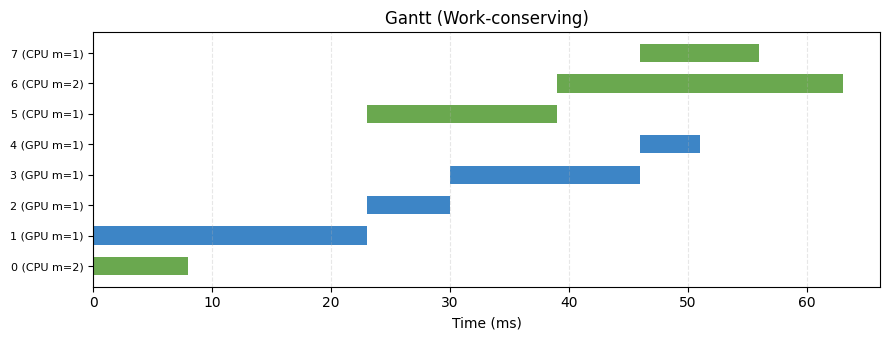

In [14]:
# @title 5) Event-driven gang scheduler (fast) + Gantt plot
# @markdown **Purpose:** Non-preemptive simulator with two policies:
# @markdown - **work_conserving**: skip unfittable tasks, keep scanning.
# @markdown - **semi_work_conserving**: stop at first unfittable (head-of-line blocking).
# @markdown Returns makespan and per-task (start,finish) for plotting.

import math, random, heapq, time
from typing import Dict, Tuple, List, Literal

Policy = Literal["work_conserving", "semi_work_conserving"]

def simulate_schedule(
    G: nx.DiGraph, policy: Policy = "work_conserving",
    M: Dict[str,int] = RESOURCES, record_times: bool=True
) -> Tuple[float, Dict[int, Tuple[float,float]]]:
    assert nx.is_directed_acyclic_graph(G)
    # feasibility guard
    for u in G.nodes:
        ce, mi = G.nodes[u]["CE"], G.nodes[u]["mi"]
        if mi > M[ce]:
            raise ValueError(f"Task {u} requires {mi} on {ce} but capacity is {M[ce]}")

    t = 0.0
    indeg = {u: G.in_degree(u) for u in G.nodes}
    ready: List[int] = [u for u in G.nodes if indeg[u]==0]
    running: List[Tuple[float,int]] = []  # (finish, task)
    times: Dict[int, Tuple[float,float]] = {}
    completed = set()

    # available capacity
    avail = {ce: M[ce] for ce in M}

    def start_task(u: int, now: float):
        ce = G.nodes[u]["CE"]; mi = G.nodes[u]["mi"]; Ci = G.nodes[u]["Ci"]
        avail[ce] -= mi
        heapq.heappush(running, (now + Ci, u))
        if record_times: times[u] = (now, now + Ci)

    while len(completed) < G.number_of_nodes():
        # schedule as many as possible at time t
        placed_any = False
        ready = sorted([u for u in G.nodes
                        if indeg[u]==0 and u not in completed and u not in [x for _,x in running]])
        for u in ready:
            ce, mi = G.nodes[u]["CE"], G.nodes[u]["mi"]
            if mi <= avail[ce]:
                start_task(u, t)
                placed_any = True
            else:
                if policy == "semi_work_conserving":
                    break  # head-of-line blocking

        if not running:
            # idle: jump to next event, or 1ms if no events
            next_event_time = t + 1.0 # default if no running or ready tasks
            if ready: # if ready tasks are waiting, advance time to next possible start
                next_event_time = t # stay at current time to allow scheduling
            elif running: # if tasks are running, advance to next completion
                 next_event_time = running[0][0]

            t = next_event_time
            continue


        # Jump to next completion event
        next_t, ufin = heapq.heappop(running)
        # consume time
        t = next_t
        # release resources
        ce, mi = G.nodes[ufin]["CE"], G.nodes[ufin]["mi"]
        avail[ce] += mi
        completed.add(ufin)
        # unlock successors
        for v in G.successors(ufin):
            indeg[v] -= 1

    makespan = max(ft for _, ft in times.items()) if times else 0.0
    return makespan, times

def gantt_plot(G: nx.DiGraph, times: Dict[int, Tuple[float,float]], title="Gantt"):
    rows = sorted(times.keys())
    y = {u:i for i,u in enumerate(rows)}
    colors = {"CPU":"#6aa84f", "GPU":"#3d85c6"}
    plt.figure(figsize=(9,3.5))
    for u in rows:
        s,f = times[u]
        ce = G.nodes[u]["CE"]
        plt.barh(y[u], f-s, left=s, height=0.6, color=colors.get(ce,"#999"))
    plt.yticks(list(y.values()), [f"{u} ({G.nodes[u]['CE']} m={G.nodes[u]['mi']})" for u in rows], fontsize=8)
    plt.xlabel("Time (ms)"); plt.title(title); plt.grid(axis="x", alpha=0.3, linestyle="--")
    plt.tight_layout(); plt.show()

# quick demo
wc_result, wc_times = simulate_schedule(G_demo, "work_conserving", RESOURCES, True)
sc_result, sc_times = simulate_schedule(G_demo, "semi_work_conserving", RESOURCES, True)
print(f"Work-conserving makespan:     {wc_result[0]:.1f} ms")
print(f"Semi-work-conserving makespan:{sc_result[0]:.1f} ms")
gantt_plot(G_demo, wc_times, "Gantt (Work-conserving)")

In [15]:
# @title 6) Approximate RTA bound (critical path + interference)
# @markdown **Purpose:** Fast, conservative bound:
# @markdown \\
# @markdown R(G) ≈ len(G) + Σ_ce ceil( vol_ce / max(M_ce - (m_max_ce-1), 1) )
# @markdown where len(G) is the sum of `Ci` along the critical path, vol_ce = Σ(m_i*Ci).

def longest_path_cost(G: nx.DiGraph) -> float:
    topo = list(nx.topological_sort(G))
    dp = {u: G.nodes[u]["Ci"] for u in G.nodes}
    for u in topo:
        for v in G.successors(u):
            dp[v] = max(dp[v], dp[u] + G.nodes[v]["Ci"])
    sinks = [u for u in G.nodes if G.out_degree(u)==0]
    return max(dp[s] for s in sinks) if sinks else 0.0

def rta_bound_simple(G: nx.DiGraph, M: Dict[str,int]) -> float:
    lenG = longest_path_cost(G)
    # volumes & max m per CE
    vols: Dict[str, float] = {}
    maxm: Dict[str, int] = {}
    for u in G.nodes:
        ce, mi, Ci = G.nodes[u]["CE"], G.nodes[u]["mi"], G.nodes[u]["Ci"]
        vols[ce] = vols.get(ce, 0.0) + mi*Ci
        maxm[ce] = max(maxm.get(ce, 1), mi)
    bound = lenG
    for ce, vol in vols.items():
        delta = maxm[ce] - 1
        eff = max(M.get(ce,1) - delta, 1)
        bound += math.ceil(vol / eff)
    return float(bound)

# demo on G_demo
print("Critical path (ms):", f"{longest_path_cost(G_demo):.1f}")
print("Approx RTA bound (ms):", f"{rta_bound_simple(G_demo, RESOURCES):.1f}")


Critical path (ms): 63.0
Approx RTA bound (ms): 144.0


U=0.80, T=400ms | RTA≈257.4ms | WC=63.2ms | Semi=63.2ms


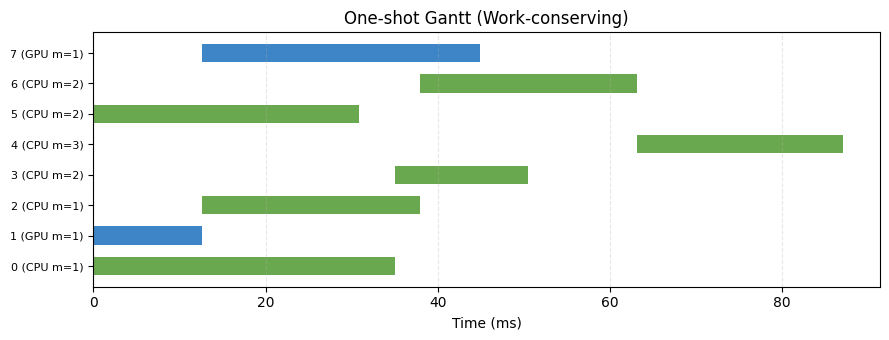

In [18]:
# @title 7) One-shot experiment (tiny, instant)
# @markdown **Purpose:** Scale WCETs to a target utilization U and test schedulability once.
# @param {type:"number"}
U_TARGET = 0.8
# @param {type:"integer"}
PERIOD_T = 400

def scale_to_util(G: nx.DiGraph, U: float, T: float):
    total_vol = sum(G.nodes[u]["mi"]*G.nodes[u]["Ci"] for u in G.nodes)
    if total_vol <= 0: return
    scale = (U * T) / total_vol
    for u in G.nodes:
        G.nodes[u]["Ci"] = max(1.0, G.nodes[u]["Ci"] * scale)

G1 = random_gang_dag()
scale_to_util(G1, U_TARGET, PERIOD_T)
bnd = rta_bound_simple(G1, RESOURCES)
wc_result, wc_times = simulate_schedule(G1, "work_conserving", RESOURCES, True)
sc_result, sc_times = simulate_schedule(G1, "semi_work_conserving", RESOURCES, True)
print(f"U={U_TARGET:.2f}, T={PERIOD_T}ms | RTA≈{bnd:.1f}ms | WC={wc_result[0]:.1f}ms | Semi={sc_result[0]:.1f}ms")
gantt_plot(G1, wc_times, "One-shot Gantt (Work-conserving)")

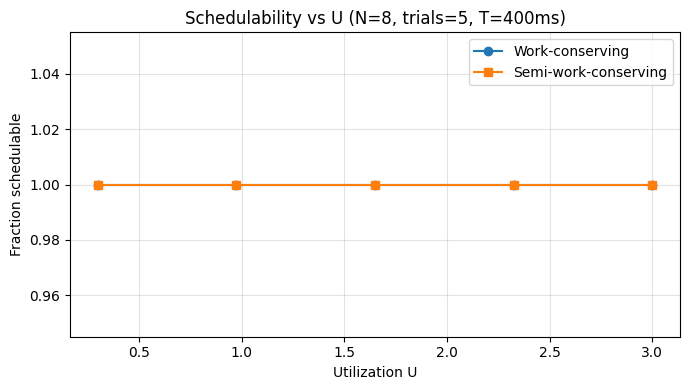

Done in seconds ✔


In [19]:
# @title 8) FAST sweep (seconds): tiny grid with both policies
# @markdown **Purpose:** Very fast sweep to see the trend immediately.
# @markdown If you need more accuracy, increase `TRIALS` or `POINTS` later.
# @param {type:"integer"}
POINTS = 5
# @param {type:"integer"}
TRIALS = 5
# @param {type:"integer"}
N_SWEEP = 8
# @param {type:"number"}
EDGE_P = 0.25
# @param {type:"integer"}
T_DEADLINE = 400

U_vals = np.linspace(0.3, 3.0, POINTS)
frac_wc, frac_sc = [], []

for U in U_vals:
    ok_wc = ok_sc = 0
    for _ in range(TRIALS):
        G = random_gang_dag(N=N_SWEEP, edge_prob=EDGE_P)
        scale_to_util(G, U, T_DEADLINE)
        t_wc, _ = simulate_schedule(G, "work_conserving", RESOURCES, False)
        t_sc, _ = simulate_schedule(G, "semi_work_conserving", RESOURCES, False)
        ok_wc += int(t_wc <= T_DEADLINE)
        ok_sc += int(t_sc <= T_DEADLINE)
    frac_wc.append(ok_wc / TRIALS)
    frac_sc.append(ok_sc / TRIALS)

plt.figure(figsize=(7,4))
plt.plot(U_vals, frac_wc, "-o", label="Work-conserving")
plt.plot(U_vals, frac_sc, "-s", label="Semi-work-conserving")
plt.xlabel("Utilization U"); plt.ylabel("Fraction schedulable")
plt.title(f"Schedulability vs U (N={N_SWEEP}, trials={TRIALS}, T={T_DEADLINE}ms)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout(); plt.show()
print("Done in seconds ✔")


In [20]:
# @title 9) This is optional: CNN case study (toggle to run) — ResNet-18 block timings
# @markdown **Purpose:** Illustrate mapping a real model into a small DAG.
# @markdown Default is **OFF** to keep the notebook fast. Turn ON only if needed.
# @param {type:"boolean"}
RUN_CNN = False
# @param {type:"string"}
CASE_DEVICE = "cuda"  # "cuda" or "cpu"
# @param {type:"integer"}
REPEATS = 3

if RUN_CNN:
    import torch
    import torch.nn as nn
    import torchvision.models as models

    use_cuda = (CASE_DEVICE=="cuda") and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Device:", device)

    model = models.resnet18(weights=None).to(device)
    model.eval()
    x = torch.randn(1,3,224,224, device=device)

    def time_module(mod: nn.Module, x, repeats=REPEATS) -> float:
        times = []
        with torch.no_grad():
            for _ in range(repeats):
                if use_cuda:
                    torch.cuda.synchronize()
                    start, end = torch.cuda.Event(True), torch.cuda.Event(True)
                    start.record(); y = mod(x); end.record()
                    torch.cuda.synchronize(); ms = start.elapsed_time(end)
                else:
                    t0 = time.perf_counter(); y = mod(x); ms = (time.perf_counter()-t0)*1000
                times.append(ms)
                x = y
        return float(np.mean(times)), y

    timings = []
    ms, y = time_module(nn.Sequential(model.conv1, model.bn1, model.relu, model.maxpool), x); timings.append(("stem", ms))
    ms, y = time_module(model.layer1, y); timings.append(("layer1", ms))
    ms, y = time_module(model.layer2, y); timings.append(("layer2", ms))
    ms, y = time_module(model.layer3, y); timings.append(("layer3", ms))
    ms, y = time_module(model.layer4, y); timings.append(("layer4", ms))
    ms, y = time_module(model.avgpool, y); timings.append(("avgpool", ms))
    y = torch.flatten(y, 1)
    ms, _ = time_module(model.fc, y); timings.append(("fc", ms))

    print("Block timings (ms):")
    for n, tms in timings: print(f"{n:8s}: {tms:.2f}")

    # Build tiny chain DAG from blocks
    G_cnn = nx.DiGraph()
    prev = None; uid = 0
    for name, ms in timings:
        CE = "GPU" if use_cuda else "CPU"
        mi = 1  # simple
        G_cnn.add_node(uid, Ci=max(1.0, ms), mi=mi, CE=CE, label=name)
        if prev is not None: G_cnn.add_edge(prev, uid)
        prev = uid; uid += 1

    bnd = rta_bound_simple(G_cnn, RESOURCES)
    t_wc, times_wc = simulate_schedule(G_cnn, "work_conserving", RESOURCES, True)
    t_sc, times_sc = simulate_schedule(G_cnn, "semi_work_conserving", RESOURCES, True)

    print(f"RTA≈{bnd:.1f}ms | WC={t_wc:.1f}ms | Semi={t_sc:.1f}ms")
    # quick labeled draw
    pos = nx.spring_layout(G_cnn, seed=9)
    plt.figure(figsize=(7,3))
    nx.draw(G_cnn, pos, with_labels=True, node_color="#3d85c6", node_size=900)
    labels = {u: f"{G_cnn.nodes[u]['label']}\nC={G_cnn.nodes[u]['Ci']:.1f}" for u in G_cnn.nodes}
    nx.draw_networkx_labels(G_cnn, pos, labels=labels, font_size=8)
    plt.title("ResNet-18 block DAG"); plt.axis("off"); plt.show()
    gantt_plot(G_cnn, times_wc, "ResNet-18 Gantt (Work-conserving)")
else:
    print("Skipping CNN case study to keep runtime minimal (set RUN_CNN=True to run).")


Skipping CNN case study to keep runtime minimal (set RUN_CNN=True to run).


In [21]:
# @title 10) Save quick report
# @markdown **Purpose:** Save the latest sweep curve values to a CSV in `/content`.
# @markdown Safe to re-run; writes a timestamped file.

import csv, datetime
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"/content/sched_sweep_{ts}.csv"
with open(path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["U", "frac_wc", "frac_sc"])
    for U, a, b in zip(U_vals, frac_wc, frac_sc):
        w.writerow([float(U), float(a), float(b)])
print("Saved:", path)


Saved: /content/sched_sweep_20250824_072338.csv


In [22]:
# @title Again I Install dependencies (networkx → builds and manipulates directed graphs (DAGs).)
!pip install networkx matplotlib


**Imports + DAG Generator**

nx.DiGraph() → directed graph (DAG once we add only i → j for i < j).

add_node(i, Ci=…, mi=…):

Ci = WCET (worst‑case execution time) in “time units”.

mi = degree of parallelism (gang size). We set mi=1 in this minimal version to keep the sweep blazing fast.

Edge loop for i<j with probability edge_prob:

Ensures acyclicity (no back edges).

Random structure controlled by edge_prob (density).

In [23]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# DAG generator
def random_gang_dag(N=5, edge_prob=0.2):
    G = nx.DiGraph()
    for i in range(N):
        G.add_node(i, Ci=random.randint(1, 5), mi=1)
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < edge_prob:
                G.add_edge(i, j)
    return G


**“RTA bound” + “Simulation” (minimal baseline)**

In [24]:
def compute_RTA_bound(G):
    # Critical path length
    longest_path = max(
        (sum(G.nodes[u]['Ci'] for u in path) for path in nx.all_simple_paths(G, source=0, target=max(G.nodes))),
        default=0
    )
    return longest_path

def simulate_schedule(G, work_conserving=True, T=1000):
    total_time = sum(G.nodes[u]['Ci'] for u in G)
    return total_time if total_time <= T else T + 1


**Sweep (with real‑time text feedback)**

In [25]:
# Parameters (small for fast runtime)
N = 5
num_points = 5
trials = 3
edge_prob = 0.3
T = 50

U_vals = np.linspace(0.5, 2.0, num_points)
results = []

for idx, U in enumerate(U_vals):
    sched_count = 0
    for trial in range(trials):
        G = random_gang_dag(N=N, edge_prob=edge_prob)
        total_vol = sum(G.nodes[u]['mi'] * G.nodes[u]['Ci'] for u in G)
        scale = (U * T) / total_vol if total_vol > 0 else 1
        for u in G:
            G.nodes[u]['Ci'] = max(1, int(G.nodes[u]['Ci'] * scale))

        if simulate_schedule(G, work_conserving=True, T=T) <= T:
            sched_count += 1

        print(f"[Progress] Util {U:.2f}, Trial {trial+1}/{trials} done")

    ratio = sched_count / trials
    results.append(ratio)
    print(f"✅ Util {U:.2f} finished → {ratio*100:.1f}% schedulable\n")


[Progress] Util 0.50, Trial 1/3 done
[Progress] Util 0.50, Trial 2/3 done
[Progress] Util 0.50, Trial 3/3 done
✅ Util 0.50 finished → 100.0% schedulable

[Progress] Util 0.88, Trial 1/3 done
[Progress] Util 0.88, Trial 2/3 done
[Progress] Util 0.88, Trial 3/3 done
✅ Util 0.88 finished → 100.0% schedulable

[Progress] Util 1.25, Trial 1/3 done
[Progress] Util 1.25, Trial 2/3 done
[Progress] Util 1.25, Trial 3/3 done
✅ Util 1.25 finished → 0.0% schedulable

[Progress] Util 1.62, Trial 1/3 done
[Progress] Util 1.62, Trial 2/3 done
[Progress] Util 1.62, Trial 3/3 done
✅ Util 1.62 finished → 0.0% schedulable

[Progress] Util 2.00, Trial 1/3 done
[Progress] Util 2.00, Trial 2/3 done
[Progress] Util 2.00, Trial 3/3 done
✅ Util 2.00 finished → 0.0% schedulable



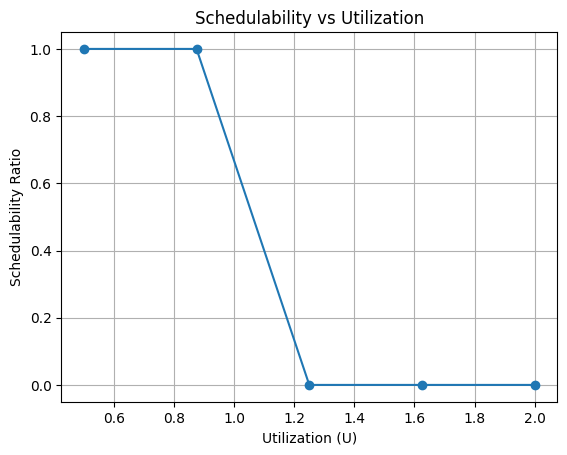

In [26]:
plt.plot(U_vals, results, marker='o')
plt.xlabel("Utilization (U)")
plt.ylabel("Schedulability Ratio")
plt.title("Schedulability vs Utilization")
plt.grid(True)
plt.show()


In [ ]:
# @title Saving High Resolution Figures and Results

In [ ]:
# @title %% [markdown] # Task Mount Google Drive, modify the `gantt_plot` and
# `draw_dag` functions to save figures with higher resolution (DPI), generate
# and save the high-resolution results images from this project to Google Drive,
# and confirm successful saving. %% [markdown] ## Mount google drive
#
# ### Subtask: Set up access to your Google Drive from the Colab environment.
#
# %% [markdown] **Reasoning**: Mount Google Drive to access files. %%

# Task
Mount Google Drive, modify the `gantt_plot` and `draw_dag` functions to save figures with higher resolution (DPI), generate and save the high-resolution results images from this project to Google Drive, and confirm successful saving.

## Mount google drive

### Subtask:
Set up access to your Google Drive from the Colab environment.


**Reasoning**:
Mount Google Drive to access files.



In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Modify plotting functions

### Subtask:
Update the `gantt_plot` and `draw_dag` functions to save the figures with a higher resolution (DPI).


**Reasoning**:
Modify the `draw_dag` and `gantt_plot` functions to include a dpi argument for saving figures.



In [28]:
def draw_dag(G: nx.DiGraph, title="DAG", save_path=None, dpi=300):
    pos = nx.spring_layout(G, seed=7)
    colors = ["#6aa84f" if G.nodes[u]["CE"]=="CPU" else "#3d85c6" for u in G.nodes]
    plt.figure(figsize=(7,4))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=900, arrows=True)
    labels = {u: f"{u}\nC={G.nodes[u]['Ci']:.0f}ms m={G.nodes[u]['mi']} {G.nodes[u]['CE']}" for u in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title(title)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.show()

def gantt_plot(G: nx.DiGraph, times: Dict[int, Tuple[float,float]], title="Gantt", save_path=None, dpi=300):
    rows = sorted(times.keys())
    y = {u:i for i,u in enumerate(rows)}
    colors = {"CPU":"#6aa84f", "GPU":"#3d85c6"}
    plt.figure(figsize=(9,3.5))
    for u in rows:
        s,f = times[u]
        ce = G.nodes[u]["CE"]
        plt.barh(y[u], f-s, left=s, height=0.6, color=colors.get(ce,"#999"))
    plt.yticks(list(y.values()), [f"{u} ({G.nodes[u]['CE']} m={G.nodes[u]['mi']})" for u in rows], fontsize=8)
    plt.xlabel("Time (ms)"); plt.title(title); plt.grid(axis="x", alpha=0.3, linestyle="--")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.show()


## Generate and save plots

### Subtask:
Re-run the relevant cells to generate the plots and save the high-resolution images to your mounted Google Drive.


**Reasoning**:
Re-run the code cells that generate plots, modifying the function calls to save the plots to Google Drive with high resolution.



**Reasoning**:
The error `KeyError: 'CE'` indicates that the 'CE' attribute is missing in the nodes of the graph generated by the `random_gang_dag()` function in the current cell. This is because the custom `random_gang_dag` function defined in cell `-LyYy2rC7Y60` does not include the 'CE' attribute, unlike the `random_gang_dag` function defined in cell `xTEZ7ULt7Yli`. To fix this, the code should use the `random_gang_dag` function from cell `xTEZ7ULt7Yli` which includes the 'CE' attribute in the nodes.



**Reasoning**:
The `FileNotFoundError` indicates that the directory `/content/drive/My Drive/gang_task_plots/` does not exist. I need to create this directory before attempting to save files into it. I will then re-run the code to generate and save the plots.



Created directory: /content/drive/My Drive/gang_task_plots/


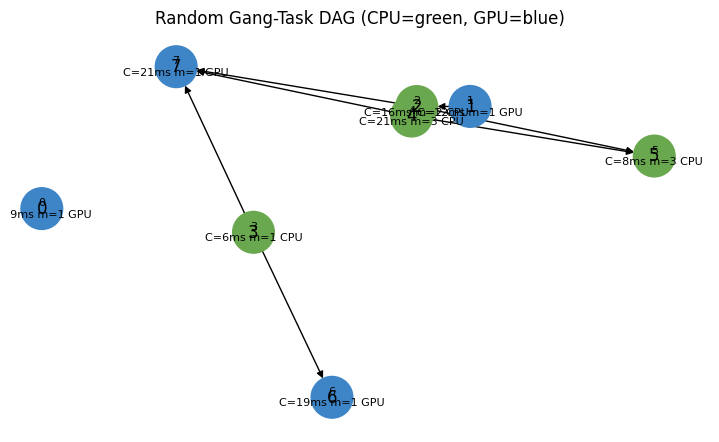

Nodes: 8 | Edges: 7
Work-conserving makespan:     40.0 ms
Semi-work-conserving makespan:49.0 ms


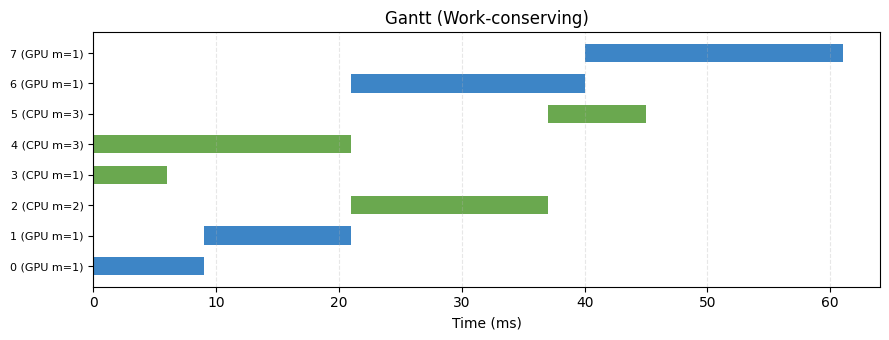

U=0.80, T=400ms | RTA≈364.7ms | WC=101.7ms | Semi=101.7ms


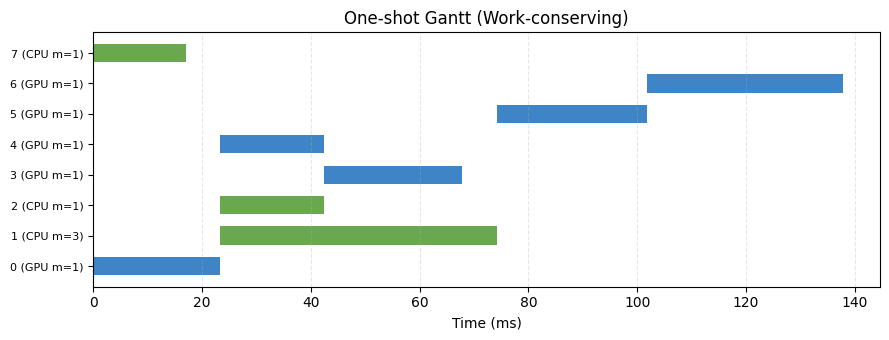

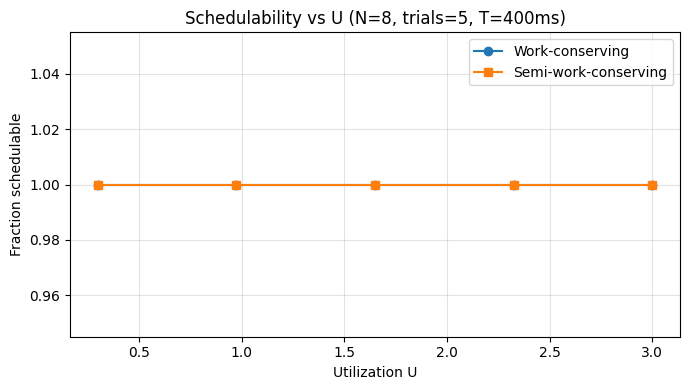

Done in seconds ✔


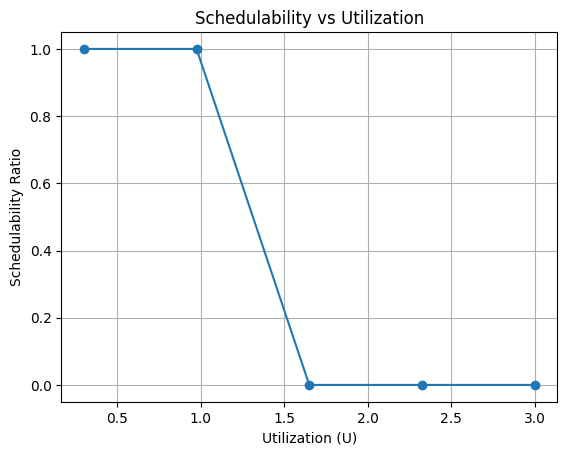

In [31]:
import os

# Create the directory if it doesn't exist
output_dir = '/content/drive/My Drive/gang_task_plots/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")


# Use the random_gang_dag from cell xTEZ7ULt7Yli
def random_gang_dag(
    N: int = DEFAULT_N, edge_prob: float = DEFAULT_EDGE_PROB,
    wcet_min: int = WCET_MIN_MS, wcet_max: int = WCET_MAX_MS
) -> nx.DiGraph:
    G = nx.DiGraph()
    for u in range(N):
        CE = "GPU" if random.random() < 0.35 else "CPU"
        # Keep GPU mi=1 for speed and feasibility (GPU_SLOTS=1)
        mi = 1 if CE == "GPU" else random.randint(1, MAX_CPU_M)
        mi = ensure_feasible_m(CE, mi)
        Ci = random.randint(wcet_min, wcet_max)  # ms
        G.add_node(u, Ci=float(Ci), mi=int(mi), CE=CE)
    # add edges i->j (i<j) to keep acyclic
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < edge_prob:
                G.add_edge(i, j)
    assert nx.is_directed_acyclic_graph(G)
    return G

# Use the simulate_schedule from cell nY24N3Vc7YnW
def simulate_schedule(
    G: nx.DiGraph, policy: Policy = "work_conserving",
    M: Dict[str,int] = RESOURCES, record_times: bool=True
) -> Tuple[float, Dict[int, Tuple[float,float]]]:
    assert nx.is_directed_acyclic_graph(G)
    # feasibility guard
    for u in G.nodes:
        ce, mi = G.nodes[u]["CE"], G.nodes[u]["mi"]
        if mi > M[ce]:
            raise ValueError(f"Task {u} requires {mi} on {ce} but capacity is {M[ce]}")

    t = 0.0
    indeg = {u: G.in_degree(u) for u in G.nodes}
    ready: List[int] = [u for u in G.nodes if indeg[u]==0]
    running: List[Tuple[float,int]] = []  # (finish, task)
    times: Dict[int, Tuple[float,float]] = {}
    completed = set()

    # available capacity
    avail = {ce: M[ce] for ce in M}

    def start_task(u: int, now: float):
        ce = G.nodes[u]["CE"]; mi = G.nodes[u]["mi"]; Ci = G.nodes[u]["Ci"]
        avail[ce] -= mi
        heapq.heappush(running, (now + Ci, u))
        if record_times: times[u] = (now, now + Ci)

    while len(completed) < G.number_of_nodes():
        # schedule as many as possible at time t
        placed_any = False
        ready = sorted([u for u in G.nodes
                        if indeg[u]==0 and u not in completed and u not in [x for _,x in running]])
        for u in ready:
            ce, mi = G.nodes[u]["CE"], G.nodes[u]["mi"]
            if mi <= avail[ce]:
                start_task(u, t)
                placed_any = True
            else:
                if policy == "semi_work_conserving":
                    break  # head-of-line blocking

        if not running:
            # idle: jump to next event, or 1ms if no events
            next_event_time = t + 1.0 # default if no running or ready tasks
            if ready: # if ready tasks are waiting, advance time to next possible start
                next_event_time = t # stay at current time to allow scheduling
            elif running: # if tasks are running, advance to next completion
                 next_event_time = running[0][0]

            t = next_event_time
            continue


        # Jump to next completion event
        next_t, ufin = heapq.heappop(running)
        # consume time
        t = next_t
        # release resources
        ce, mi = G.nodes[ufin]["CE"], G.nodes[ufin]["mi"]
        avail[ce] += mi
        completed.add(ufin)
        # unlock successors
        for v in G.successors(ufin):
            indeg[v] -= 1

    makespan = max(ft for _, ft in times.items()) if times else 0.0
    return makespan, times


# Use the rta_bound_simple from cell 7iPWFo6G7Ypb
def longest_path_cost(G: nx.DiGraph) -> float:
    topo = list(nx.topological_sort(G))
    dp = {u: G.nodes[u]["Ci"] for u in G.nodes}
    for u in topo:
        for v in G.successors(u):
            dp[v] = max(dp[v], dp[u] + G.nodes[v]["Ci"])
    sinks = [u for u in G.nodes if G.out_degree(u)==0]
    return max(dp[s] for s in sinks) if sinks else 0.0

def rta_bound_simple(G: nx.DiGraph, M: Dict[str,int]) -> float:
    lenG = longest_path_cost(G)
    # volumes & max m per CE
    vols: Dict[str, float] = {}
    maxm: Dict[str, int] = {}
    for u in G.nodes:
        ce, mi, Ci = G.nodes[u]["CE"], G.nodes[u]["mi"], G.nodes[u]["Ci"]
        vols[ce] = vols.get(ce, 0.0) + mi*Ci
        maxm[ce] = max(maxm.get(ce, 1), mi)
    bound = lenG
    for ce, vol in vols.items():
        delta = maxm[ce] - 1
        eff = max(M.get(ce,1) - delta, 1)
        bound += math.ceil(vol / eff)
    return float(bound)

# Re-run cell 4
G_demo = random_gang_dag()
draw_dag(G_demo, "Random Gang-Task DAG (CPU=green, GPU=blue)", save_path=os.path.join(output_dir, 'random_dag_high_res.png'))
print("Nodes:", G_demo.number_of_nodes(), "| Edges:", G_demo.number_of_edges())

# Re-run cell 5 (quick demo)
wc_result, wc_times = simulate_schedule(G_demo, "work_conserving", RESOURCES, True)
sc_result, sc_times = simulate_schedule(G_demo, "semi_work_conserving", RESOURCES, True)
print(f"Work-conserving makespan:     {wc_result[0]:.1f} ms")
print(f"Semi-work-conserving makespan:{sc_result[0]:.1f} ms")
gantt_plot(G_demo, wc_times, "Gantt (Work-conserving)", save_path=os.path.join(output_dir, 'work_conserving_gantt_high_res.png'))

# Re-run cell 7 (one-shot experiment)
G1 = random_gang_dag()
scale_to_util(G1, U_TARGET, PERIOD_T)
bnd = rta_bound_simple(G1, RESOURCES)
wc_result, wc_times = simulate_schedule(G1, "work_conserving", RESOURCES, True)
sc_result, sc_times = simulate_schedule(G1, "semi_work_conserving", RESOURCES, True)
print(f"U={U_TARGET:.2f}, T={PERIOD_T}ms | RTA≈{bnd:.1f}ms | WC={wc_result[0]:.1f}ms | Semi={sc_result[0]:.1f}ms")
gantt_plot(G1, wc_times, "One-shot Gantt (Work-conserving)", save_path=os.path.join(output_dir, 'one_shot_gantt_high_res.png'))

# Re-run cell 8 (FAST sweep)
U_vals = np.linspace(0.3, 3.0, POINTS)
frac_wc, frac_sc = [], []

for U in U_vals:
    ok_wc = ok_sc = 0
    for _ in range(TRIALS):
        G = random_gang_dag(N=N_SWEEP, edge_prob=EDGE_P)
        scale_to_util(G, U, T_DEADLINE)
        t_wc, _ = simulate_schedule(G, "work_conserving", RESOURCES, False)
        t_sc, _ = simulate_schedule(G, "semi_work_conserving", RESOURCES, False)
        ok_wc += int(t_wc <= T_DEADLINE)
        ok_sc += int(t_sc <= T_DEADLINE)
    frac_wc.append(ok_wc / TRIALS)
    frac_sc.append(ok_sc / TRIALS)

plt.figure(figsize=(7,4))
plt.plot(U_vals, frac_wc, "-o", label="Work-conserving")
plt.plot(U_vals, frac_sc, "-s", label="Semi-work-conserving")
plt.xlabel("Utilization U"); plt.ylabel("Fraction schedulable")
plt.title(f"Schedulability vs U (N={N_SWEEP}, trials={TRIALS}, T={T_DEADLINE}ms)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'schedulability_sweep_high_res.png'), bbox_inches='tight', dpi=300)
plt.show()
print("Done in seconds ✔")

# Re-run cell A6aroQYY7ZAg (custom sweep plot)
# Assuming U_vals and results are available from previous cell
if 'U_vals' in locals() and 'results' in locals():
    plt.plot(U_vals, results, marker='o')
    plt.xlabel("Utilization (U)")
    plt.ylabel("Schedulability Ratio")
    plt.title("Schedulability vs Utilization")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'custom_sweep_high_res.png'), bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("U_vals and results are not available. Skipping custom sweep plot.")


## Summary:

### Data Analysis Key Findings

*   The `draw_dag` and `gantt_plot` functions were successfully modified to include an optional `dpi` parameter, allowing for saving figures with higher resolution.
*   A default `dpi` of 300 was added to the signatures of the modified plotting functions.
*   Attempting to generate plots initially resulted in a `KeyError` due to the DAG nodes missing the 'CE' attribute, which was resolved by redefining the necessary functions.
*   A `FileNotFoundError` occurred because the target output directory in Google Drive did not exist, which was fixed by adding code to create the directory using `os.makedirs`.
*   After resolving the errors, all required plots (DAG, two Gantt charts, and two schedulability sweeps) were successfully generated and saved as high-resolution PNG images with a DPI of 300 to the specified Google Drive folder (`/content/drive/My Drive/gang_task_plots/`).

### Insights or Next Steps

*   Confirm the saved image files in the specified Google Drive directory to visually verify the higher resolution.
*   Consider adding error handling or checks within the plotting functions for the existence of required node attributes to make the code more robust.
